# 6. Consumer Fraud Probability Prediction

## 6.1 Merge for processing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA

In [4]:
# Read data
transaction_consumer = pd.read_parquet('../data/curated/transaction/transaction_consumer_cleaned.parquet')
merchant = pd.read_csv('../data/curated/merchant/merchant_cleaned2.csv')

In [5]:
# check how many unique consumer_id in transaction_consumer
print('Number of unique consumer_id in transaction_consumer: ', transaction_consumer['consumer_id'].nunique())
# check how many rows in transaction_consumer
print('Number of rows in transaction_consumer: ', transaction_consumer.shape[0])

Number of unique consumer_id in transaction_consumer:  24081
Number of rows in transaction_consumer:  14168972


In [6]:
# merge merchant with transaction_consumer by merchant_abn
transaction_consumer_merchant = pd.merge(transaction_consumer, merchant, how='left', on='merchant_abn')

In [7]:
transaction_consumer_merchant.isna().sum()

user_id                0
merchant_abn           0
dollar_value           0
order_id               0
order_datetime         0
Unnamed: 0             0
name_x                 0
address                0
state                  0
postcode               0
gender                 0
consumer_id            0
name_y            580119
goods             580119
revenue_level     580119
take_rate         580119
first_word        580119
dtype: int64

In [8]:
transaction_consumer_merchant.dropna(inplace=True)
# transaction_consumer_merchant.to_parquet('../data/curated/transaction/total_info.parquet')

In [9]:
# check unique order_id
print('Number of unique order_id in transaction_consumer_merchant: ', transaction_consumer_merchant['order_id'].nunique())
# print total number of rows
print('Number of rows in transaction_consumer_merchant: ', len(transaction_consumer_merchant))

Number of unique order_id in transaction_consumer_merchant:  13588853
Number of rows in transaction_consumer_merchant:  13588853


In [10]:
consumer_fraud = pd.read_csv('../data/tables/consumer_fraud_probability.csv')
consumer_fraud

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425
...,...,...,...
34859,18466,2022-02-22,8.679873
34860,17552,2021-12-26,8.349463
34861,17875,2021-06-27,8.288847
34862,10401,2021-09-18,8.842216


In [11]:
# merge consumer_fraud with transaction_consumer_merchant by user_id and order_datetime
transaction_with_consumer_fraud = pd.merge(transaction_consumer_merchant, consumer_fraud, how='left', on=['user_id', 'order_datetime'])

In [12]:
# rename the column
transaction_with_consumer_fraud.rename(columns={
    'fraud_probability': 'consumer_fraud_probability',
    'name_x': 'consumer_name',
    'name_y': 'merchant_name',
    'first_word': 'area'
    }, inplace=True)

In [13]:
# test if the order_id is unique
print('Number of unique order_id in transaction_with_consumer_fraud: ', transaction_with_consumer_fraud['order_id'].nunique())
print('Number of rows in transaction_with_consumer_fraud: ', len(transaction_with_consumer_fraud))

Number of unique order_id in transaction_with_consumer_fraud:  13588853
Number of rows in transaction_with_consumer_fraud:  13589025


In [14]:
# check this not unique order_id transactions
transaction_with_consumer_fraud[transaction_with_consumer_fraud['order_id'].duplicated(keep=False)]

,user_id,merchant_abn,dollar_value,order_id,order_datetime,Unnamed: 0,consumer_name,address,state,postcode,gender,consumer_id,merchant_name,goods,revenue_level,take_rate,area,consumer_fraud_probability
2824092,11702,50866797623,301.929549,3ba20ce5-9d8a-4022-9b92-7c8a6595e07d,2021-07-27,11701,Ana Robinson,77844 Garcia Valley Suite 431,TAS,7466,Female,165107,Cum Sociis Natoque Incorporated,gift card novelty souvenir shop,c,2.82,gift,74.196769
2824093,11702,50866797623,301.929549,3ba20ce5-9d8a-4022-9b92-7c8a6595e07d,2021-07-27,11701,Ana Robinson,77844 Garcia Valley Suite 431,TAS,7466,Female,165107,Cum Sociis Natoque Incorporated,gift card novelty souvenir shop,c,2.82,gift,74.196769
2824094,11702,53918538787,77134.214605,8584d8d1-061b-41ca-a6d2-5371fff97764,2021-07-27,11701,Ana Robinson,77844 Garcia Valley Suite 431,TAS,7466,Female,165107,In Tempus Inc.,antique shop sale repair restoration service,b,3.49,antique,74.196769
2824095,11702,53918538787,77134.214605,8584d8d1-061b-41ca-a6d2-5371fff97764,2021-07-27,11701,Ana Robinson,77844 Garcia Valley Suite 431,TAS,7466,Female,165107,In Tempus Inc.,antique shop sale repair restoration service,b,3.49,antique,74.196769
3452990,23700,89726005175,36.552762,59f3453d-72e4-49ea-9a7a-c60c220df429,2021-08-26,23699,Angela Harris,572 Shannon Plaza,NSW,1212,Undisclosed,1319595,Est Nunc Consulting,tent awning shop,a,6.01,tent,75.165555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7749411,17900,11149063370,42797.348359,b0bdd444-223a-4b4f-98f3-7e2bba125691,2022-02-25,17899,Angela Fuentes,1847 John Bridge Suite 989,NSW,2805,Female,476053,Et Arcu Limited,art dealer gallery,b,4.84,art,92.732628
7789086,3513,83199298021,44471.999391,4463230f-9745-4a4a-9f5a-2609f8d549b2,2022-02-27,3512,Ryan Wright,6031 Patrick Lane Apt. 975,WA,6350,Male,1454256,Ligula Elit Pretium Foundation,antique shop sale repair restoration service,b,4.82,antique,75.169812
7789087,3513,83199298021,44471.999391,4463230f-9745-4a4a-9f5a-2609f8d549b2,2022-02-27,3512,Ryan Wright,6031 Patrick Lane Apt. 975,WA,6350,Male,1454256,Ligula Elit Pretium Foundation,antique shop sale repair restoration service,b,4.82,antique,75.169812
7789089,3513,77343745836,813.551417,aa7e52e3-98cd-4df2-93a9-7da9bdbe48df,2022-02-27,3512,Ryan Wright,6031 Patrick Lane Apt. 975,WA,6350,Male,1454256,Nunc Ullamcorper Velit LLC,health beauty spa,b,3.45,beauty,75.169812


In [15]:
# drop duplicated order_id
transaction_with_consumer_fraud.drop_duplicates(subset=['order_id'], keep='first', inplace=True)
print('Number of rows in transaction_with_consumer_fraud: ', len(transaction_with_consumer_fraud))

Number of rows in transaction_with_consumer_fraud:  13588853


In [16]:
# drop useless columns
transaction_with_consumer_fraud.drop(columns=['Unnamed: 0', 'order_id'], inplace=True)

In [17]:
# save for further use
transaction_with_consumer_fraud.to_parquet('../data/curated/transaction/transaction_with_consumer_fraud.parquet', index=False)

In [18]:
transaction_with_consumer_fraud

,user_id,merchant_abn,dollar_value,order_datetime,consumer_name,address,state,postcode,gender,consumer_id,merchant_name,goods,revenue_level,take_rate,area,consumer_fraud_probability
0,1,28000487688,133.226894,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,Sed Nunc Industries,book periodical newspaper,b,4.24,book,NaN
1,18485,62191208634,79.131400,2021-02-28,Samuel Haynes,9969 Catherine View Apt. 601,VIC,3073,Male,1212819,Cursus Non Egestas Foundation,furniture home furnishing equipment shop manuf...,c,2.17,furniture,NaN
2,1,83690644458,30.441348,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,Id Erat Etiam Consulting,gift card novelty souvenir shop,b,3.15,gift,NaN
3,18488,39649557865,962.813341,2021-02-28,Aaron Sawyer,362 Dixon Islands,WA,6646,Male,1302316,Arcu Morbi Institute,artist supply craft shop,c,1.47,art,NaN
4,2,80779820715,48.123977,2021-02-28,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208,Euismod Enim LLC,watch clock jewelry repair shop,b,4.71,jewelry,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13589020,11135,49891706470,24.174809,2022-10-26,Erin Montoya,8262 Ronald Rapid Apt. 882,NSW,2013,Female,558959,Non Vestibulum Industries,tent awning shop,a,5.80,tent,NaN
13589021,11136,24852446429,5.384811,2022-10-26,Terry Howell,4358 Robert Locks,QLD,4707,Male,841591,Erat Vitae LLP,florist supply nursery stock flower,c,2.94,housekeeping,NaN
13589022,11136,63685007785,48.129887,2022-10-26,Terry Howell,4358 Robert Locks,QLD,4707,Male,841591,Augue Eu Tempor Associates,cable satellite pay television radio service,e,0.38,telecom,NaN
13589023,11137,85502310765,4.768752,2022-10-26,Mr. Kenneth Reyes MD,01577 Shawn Square,VIC,3413,Male,505728,Magnis Dis Parturient Industries,computer programming data processing integrate...,d,0.84,computer,NaN


In [19]:
# free large memory of transactions
del transaction_consumer, transaction_consumer_merchant, consumer_fraud, transaction_with_consumer_fraud, merchant

## 6.2 Feature Selection

In [20]:
transaction_with_consumer_fraud = pd.read_parquet('../data/curated/transaction/transaction_with_consumer_fraud.parquet')

In [21]:
# drop un-needed columns
transaction_with_consumer_fraud.drop(columns=['consumer_id', 'merchant_name', 'consumer_name', 'address', 'goods'], inplace=True)

transaction_with_consumer_fraud

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability
0,1,28000487688,133.226894,2021-02-28,WA,6935,Female,b,4.24,book,NaN
1,18485,62191208634,79.131400,2021-02-28,VIC,3073,Male,c,2.17,furniture,NaN
2,1,83690644458,30.441348,2021-02-28,WA,6935,Female,b,3.15,gift,NaN
3,18488,39649557865,962.813341,2021-02-28,WA,6646,Male,c,1.47,art,NaN
4,2,80779820715,48.123977,2021-02-28,NSW,2782,Female,b,4.71,jewelry,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13588848,11135,49891706470,24.174809,2022-10-26,NSW,2013,Female,a,5.80,tent,NaN
13588849,11136,24852446429,5.384811,2022-10-26,QLD,4707,Male,c,2.94,housekeeping,NaN
13588850,11136,63685007785,48.129887,2022-10-26,QLD,4707,Male,e,0.38,telecom,NaN
13588851,11137,85502310765,4.768752,2022-10-26,VIC,3413,Male,d,0.84,computer,NaN


In [22]:
# save for further use
transaction_with_consumer_fraud.to_parquet('../data/curated/transaction/transaction_wcf_after_selection.parquet', index=False)

In [23]:
# free space
del transaction_with_consumer_fraud

## 6.3 Model fitting

In [24]:
transaction_with_consumer_fraud = pd.read_parquet('../data/curated/transaction/transaction_wcf_after_selection.parquet')

In [25]:
# leave train data only
transaction_to_predict = transaction_with_consumer_fraud.dropna()
transaction_to_predict

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability
4689,21989,31334588839,14080.096388,2021-02-28,VIC,3818,Undisclosed,b,4.22,antique,21.272297
4691,21989,14430838529,74.674454,2021-02-28,VIC,3818,Undisclosed,c,2.03,telecom,21.272297
5683,4144,45629217853,3.167339,2021-02-28,NSW,2736,Male,a,6.98,gift,9.689173
5984,4351,64203420245,49.474965,2021-02-28,NSW,2340,Female,c,2.86,tent,13.006904
6786,4952,21439773999,76.071035,2021-02-28,NSW,1234,Male,a,6.10,telecom,9.131704
...,...,...,...,...,...,...,...,...,...,...,...
7802617,14526,32173481131,3672.263901,2022-02-27,VIC,3788,Undisclosed,a,6.30,telecom,10.989992
7802629,14542,12771097467,2727.032466,2022-02-27,WA,6726,Male,a,6.95,motor,9.050576
7802789,14743,63937753588,3064.467853,2022-02-27,VIC,3933,Male,b,4.17,furniture,14.079151
7802790,14743,49322182190,113.319209,2022-02-27,VIC,3933,Male,a,6.35,jewelry,14.079151


In [26]:
# check how many merchant and user only have one transaction
merchant_count = transaction_to_predict.groupby('merchant_abn').count()
merchant_count[merchant_count['user_id'] == 1]

user_count = transaction_to_predict.groupby('user_id').count()
user_count[user_count['merchant_abn'] == 1]

# print them
print('merchant_abn with only one transaction: ', merchant_count[merchant_count['user_id'] == 1].index)
print('user_id with only one transaction: ', user_count[user_count['merchant_abn'] == 1].index)

merchant_abn with only one transaction:  Int64Index([10463252268, 10746056613, 10854978569, 10860706939, 10930486968,
            10995883576, 11024352823, 11076688542, 11633090957, 12031655138,
            ...
            97283139514, 97296257023, 98487769763, 98508290651, 99009287608,
            99063901069, 99115883676, 99217762645, 99410502449, 99802335254],
           dtype='int64', name='merchant_abn', length=496)
user_id with only one transaction:  Int64Index([    1,     3,    17,    20,    22,    33,    36,    49,    75,
               80,
            ...
            24029, 24031, 24038, 24041, 24043, 24046, 24050, 24052, 24057,
            24072],
           dtype='int64', name='user_id', length=3093)


In [27]:
# check unique user_id and merchant_abn
print('Number of unique user_id in transaction_to_predict: ', transaction_to_predict['user_id'].nunique())
print('Number of unique merchant_abn in transaction_to_predict: ', transaction_to_predict['merchant_abn'].nunique())

Number of unique user_id in transaction_to_predict:  19484
Number of unique merchant_abn in transaction_to_predict:  3081


In [28]:
categorical_features = ['state', 'gender', 'revenue_level', 'area']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(transaction_to_predict[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
encoded_df.reset_index(drop=True, inplace=True)

# # Perform PCA on one-hot encoded 'user_id' and 'merchant_abn' features
# encoded_user_id = encoder.fit_transform(transaction_to_predict[['user_id']])
# encoded_merchant_abn = encoder.fit_transform(transaction_to_predict[['merchant_abn']])

# # Apply PCA to reduce dimensionality of 'user_id' and 'merchant_abn' features
# # n_components = 100 
# pca_user_id = PCA(n_components=150).fit_transform(encoded_user_id)
# pca_merchant_abn = PCA(n_components=25).fit_transform(encoded_merchant_abn)

# # Create DataFrames with the PCA features
# user_id_pca_df = pd.DataFrame(pca_user_id, columns=[f'user_id_pca_{i}' for i in range(150)])
# merchant_abn_pca_df = pd.DataFrame(pca_merchant_abn, columns=[f'merchant_abn_pca_{i}' for i in range(25)])

# Target encoding user_id on average, std and median dollar amount
transaction_to_predict['user_id'] = transaction_to_predict['user_id'].astype('category')
transaction_to_predict['user_id'] = transaction_to_predict['user_id'].cat.codes
user_avg_dollar = transaction_to_predict.groupby('user_id')['dollar_value'].mean()
transaction_to_predict['user_avg_dollar'] = transaction_to_predict['user_id'].map(user_avg_dollar)
user_std_dollar = transaction_to_predict.groupby('user_id')['dollar_value'].std()
transaction_to_predict['user_std_dollar'] = transaction_to_predict['user_id'].map(user_std_dollar)
user_mid_dollar = transaction_to_predict.groupby('user_id')['dollar_value'].median()
transaction_to_predict['user_mid_dollar'] = transaction_to_predict['user_id'].map(user_mid_dollar)
# together with max difference
user_dollar_diff = transaction_to_predict.groupby('user_id')['dollar_value'].max() - transaction_to_predict.groupby('user_id')['dollar_value'].min()
transaction_to_predict['user_dollar_diff'] = transaction_to_predict['user_id'].map(user_dollar_diff)


# Target encoding merchant_abn on average, std and median dollar amount
transaction_to_predict['merchant_abn'] = transaction_to_predict['merchant_abn'].astype('category')
transaction_to_predict['merchant_abn'] = transaction_to_predict['merchant_abn'].cat.codes
merchant_avg_dollar = transaction_to_predict.groupby('merchant_abn')['dollar_value'].mean()
transaction_to_predict['merchant_avg_dollar'] = transaction_to_predict['merchant_abn'].map(merchant_avg_dollar)
merchant_std_dollar = transaction_to_predict.groupby('merchant_abn')['dollar_value'].std()
transaction_to_predict['merchant_std_dollar'] = transaction_to_predict['merchant_abn'].map(merchant_std_dollar)
merchant_mid_dollar = transaction_to_predict.groupby('merchant_abn')['dollar_value'].median()
transaction_to_predict['merchant_mid_dollar'] = transaction_to_predict['merchant_abn'].map(merchant_mid_dollar)
# together with max difference
merchant_dollar_diff = transaction_to_predict.groupby('merchant_abn')['dollar_value'].max() - transaction_to_predict.groupby('merchant_abn')['dollar_value'].min()
transaction_to_predict['merchant_dollar_diff'] = transaction_to_predict['merchant_abn'].map(merchant_dollar_diff)

# if merchant only have one transaction, set std to 0
transaction_to_predict['merchant_std_dollar'].fillna(0, inplace=True)
# if user only have one transaction, set std to 0
transaction_to_predict['user_std_dollar'].fillna(0, inplace=True)

transaction_to_predict.drop(['user_id', 'merchant_abn'], axis=1, inplace=True)


# encode and merge
transaction_to_predict = transaction_to_predict.drop(categorical_features, axis=1)
transaction_to_predict.reset_index(drop=True, inplace=True)
# transaction_to_predict = pd.concat([transaction_to_predict.drop(['user_id', 'merchant_abn'], axis=1), user_id_pca_df, merchant_abn_pca_df], axis=1)
transaction_to_predict = pd.concat([transaction_to_predict, encoded_df], axis=1)

# date processing
transaction_to_predict['order_datetime'] = pd.to_datetime(transaction_to_predict['order_datetime'])
transaction_to_predict['order_year'] = transaction_to_predict['order_datetime'].dt.year
transaction_to_predict['order_month'] = transaction_to_predict['order_datetime'].dt.month
transaction_to_predict['order_day'] = transaction_to_predict['order_datetime'].dt.day
transaction_to_predict.drop(['order_datetime'], axis=1, inplace=True)

# split test and train
X = transaction_to_predict.drop('consumer_fraud_probability', axis=1)
y = transaction_to_predict['consumer_fraud_probability']

/Users/lilywu/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/7z/_jc0kc7577vb65b5ddt1h0r80000gn/T/ipykernel_26755/3234556487.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_to_predict['user_id'] = transaction_to_predict['user_id'].astype('category')
/var/folders/7z/_jc0kc7577vb65b5ddt1h0r80000gn/T/ipykernel_26755/3234556487.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [29]:
X

,dollar_value,postcode,take_rate,user_avg_dollar,user_std_dollar,user_mid_dollar,user_dollar_diff,merchant_avg_dollar,merchant_std_dollar,merchant_mid_dollar,...,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy,order_year,order_month,order_day
0,14080.096388,3818,4.22,5709.933750,7392.410507,2975.030408,14005.421935,8904.851039,6296.919166,6861.293386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,28
1,74.674454,3818,2.03,5709.933750,7392.410507,2975.030408,14005.421935,60.967440,43.416952,55.912974,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2021,2,28
2,3.167339,2736,6.98,3.167339,0.000000,3.167339,0.000000,36.720713,37.480512,23.989616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,28
3,49.474965,2340,2.86,49.474965,0.000000,49.474965,0.000000,28.743289,14.713754,29.226404,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2021,2,28
4,76.071035,1234,6.10,1279.853746,2335.026993,133.658839,4710.704705,82.015194,62.038819,66.676729,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2021,2,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71287,3672.263901,3788,6.30,2189.252575,2793.348999,36.079548,5846.807068,3618.579404,899.070066,3590.240794,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2022,2,27
71288,2727.032466,6726,6.95,1695.159460,2327.905746,568.809070,6459.508138,4894.739511,2095.069154,4368.049118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,2,27
71289,3064.467853,3933,4.17,2328.307004,4036.484204,215.226159,10107.693932,4024.192593,1587.502697,3653.309681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,2,27
71290,113.319209,3933,6.35,2328.307004,4036.484204,215.226159,10107.693932,148.420173,47.699745,146.269161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,2,27


In [30]:
# do correlation analysis between features and consumer_fraud_probability and only keep consumer_fraud_probability part
corr = transaction_to_predict.corr()
corr = corr['consumer_fraud_probability']

# sort correlation
corr = corr.sort_values(ascending=False)
corr

consumer_fraud_probability    1.000000
user_std_dollar               0.556334
user_avg_dollar               0.539965
user_dollar_diff              0.509785
dollar_value                  0.413878
user_mid_dollar               0.323611
merchant_std_dollar           0.310742
merchant_dollar_diff          0.282799
merchant_avg_dollar           0.273917
merchant_mid_dollar           0.258379
area_jewelry                  0.158288
revenue_level_b               0.026676
revenue_level_c               0.020238
state_NT                      0.009332
area_gift                     0.008149
area_optician                 0.007269
gender_Male                   0.006971
order_year                    0.006346
area_book                     0.004995
state_QLD                     0.003961
state_NSW                     0.001577
state_SA                      0.001423
state_VIC                     0.001232
gender_Undisclosed            0.000791
area_motor                    0.000768
state_TAS                

In [31]:
# check how many 0s in user_id_std_dollar and merchant_abn_std_dollar in X
print('Number of 0s in user_id_std_dollar: ', (X['user_std_dollar'] == 0).sum())

# check how many nulls in user_id_std_dollar and merchant_std_dollar in X
print('Number of nulls in user_id_std_dollar: ', X['user_std_dollar'].isna().sum())
print('Number of nulls in merchant_std_dollar: ', X['merchant_std_dollar'].isna().sum())

# check how many nulls in user_mid_dollar and merchant_mid_dollar in X
print('Number of nulls in user_mid_dollar: ', X['user_mid_dollar'].isna().sum())
print('Number of nulls in merchant_mid_dollar: ', X['merchant_mid_dollar'].isna().sum())

# check how many nulls in user_dollar_diff and merchant_dollar_diff in X
print('Number of nulls in user_dollar_diff: ', X['user_dollar_diff'].isna().sum())
print('Number of nulls in merchant_dollar_diff: ', X['merchant_dollar_diff'].isna().sum())

Number of 0s in user_id_std_dollar:  3093
Number of nulls in user_id_std_dollar:  0
Number of nulls in merchant_std_dollar:  0
Number of nulls in user_mid_dollar:  0
Number of nulls in merchant_mid_dollar:  0
Number of nulls in user_dollar_diff:  0
Number of nulls in merchant_dollar_diff:  0


discrete levels

In [32]:
# separate to 6:2:2 for safe, unsure and fraud
q = [0.0, 0.6, 0.8, 1.0]
labels = ['safe', 'unsure', 'fraud']

y_classes = pd.qcut(y, q=q, labels=labels)

In [33]:
# count the number of each class
y_classes.value_counts()

safe      42776
unsure    14259
fraud     14257
Name: consumer_fraud_probability, dtype: int64

In [34]:
# 99:1 split
X_train, X_test, y_train, y_test = train_test_split(X, y_classes, test_size=0.01, random_state=42)

In [35]:
# neural network
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=42, max_iter=100).fit(X_train, y_train)

clf.predict_proba(X_test.iloc[:1])
clf.predict(X_test.iloc[:5, :])
clf.score(X_test, y_test)

/Users/lilywu/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6788218793828892

In [36]:
# random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# accuracy
print("Training accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.7868162692847125


### Performance analysis

In [37]:
# check prediction label count
y_pred = clf.predict(X_test)
pd.Series(y_pred).value_counts()

safe      522
fraud     116
unsure     75
dtype: int64

In [38]:
y_test.value_counts()

safe      445
fraud     135
unsure    133
Name: consumer_fraud_probability, dtype: int64

In [39]:
# check how many wrongs in each class
y_test = y_test.reset_index(drop=True)
wrong = y_test[y_test != y_pred]
wrong.value_counts()

# # check error rate
# wrong.value_counts() / y_test.value_counts()


unsure    79
fraud     45
safe      28
Name: consumer_fraud_probability, dtype: int64

Text(0.5, 1.0, 'Random Forest Classifier \nAccuracy:0.787')

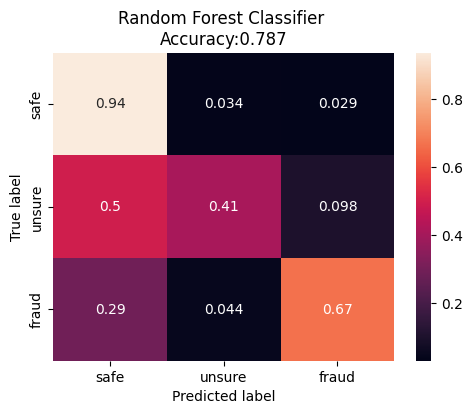

In [40]:
# draw confusion matrix in picture
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=['safe', 'unsure', 'fraud'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cm, index=['safe', 'unsure', 'fraud'], columns=['safe', 'unsure', 'fraud'])

plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_df, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))

Visualise to show that prediction is unlikely to transition to a higher risk level :)

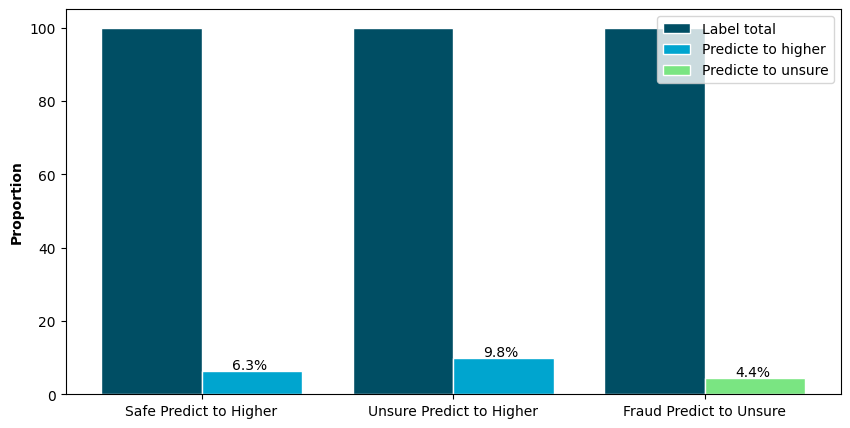

In [41]:
# safe
safe_total = 100
safe_pred_to_higher = (0.034 + 0.029) * 100
# unsure
unsure_total = 100
unsure_pred_higher = 0.098 * 100
# fraud
fraud_total = 100
fraud_pred_to_unsure = 0.044 * 100

# set width of bar
barWidth = 0.25

# set height of bar
bars1 = [safe_total, unsure_total, fraud_total]
bars2 = [safe_pred_to_higher, unsure_pred_higher, fraud_pred_to_unsure]

# Set position of bar on X axis
r1 = 0.625*np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.figure(figsize=(10, 5))
plt.bar(r1, bars1, color='#004E64', width=barWidth, edgecolor='white', label='Label total')
plt.bar(r2[:2], bars2[:2], color='#00a5cf', width=barWidth, edgecolor='white', label='Predicte to higher')
plt.bar(r2[2], bars2[2], color='#7AE582', width=barWidth, edgecolor='white', label='Predicte to unsure')

# label values
label = [str(round(x, 2)) + '%' for x in bars2]

# draw label
for i in range(len(label)):
    plt.text(x=r2[i]-0.05, y=bars2[i]+0.5, s=label[i], size=10)


plt.ylabel('Proportion', fontweight='bold')
plt.xticks([0.5 * barWidth, 3 * barWidth, 5.5 * barWidth], ['Safe Predict to Higher', 'Unsure Predict to Higher', 'Fraud Predict to Unsure'])

# Create legend & Show graphic

plt.legend()
plt.show()


Text(0.5, 1.0, 'Variable Importance')

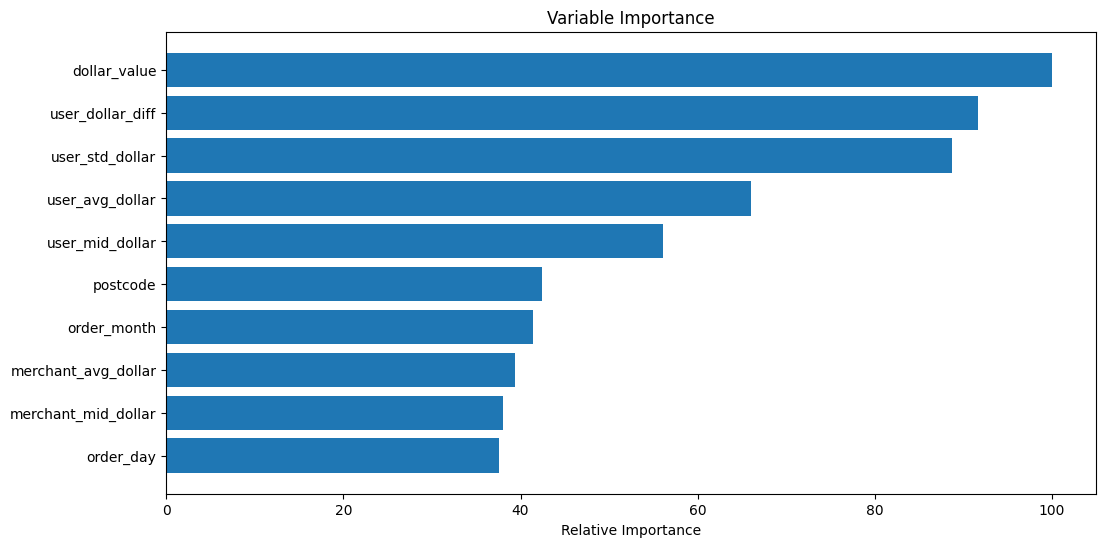

In [42]:
# draw feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Regression and check accuracy with range (a trial)

In [43]:
# # do regression directly
# from sklearn.linear_model import LinearRegression
# reg = LinearRegression().fit(X_train, y_train)

# # check accuracy with 3.384 error tolerance
# y_pred = reg.predict(X_test)
# error = abs(y_pred - y_test)
# error = np.where(error > 3.384, 1, 0)
# accuracy = 1 - (error.sum() / len(error))

# print("Accuracy with 3.384 error tolerance:", accuracy)

In [44]:
# free space
del transaction_to_predict, transaction_with_consumer_fraud

## 6.4 Predict on Dataset

imports for individual block running

In [45]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [46]:
transaction_after_selection = pd.read_parquet('../data/curated/transaction/transaction_wcf_after_selection.parquet')

In [47]:
# find transactions without fraud probability, which is to be predicted
transaction_to_predict = transaction_after_selection[transaction_after_selection['consumer_fraud_probability'].isna()]
# keep trained part(ones with fraud probability)
transaction_trained = transaction_after_selection[~transaction_after_selection['consumer_fraud_probability'].isna()]

In [48]:
transaction_trained

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability
4689,21989,31334588839,14080.096388,2021-02-28,VIC,3818,Undisclosed,b,4.22,antique,21.272297
4691,21989,14430838529,74.674454,2021-02-28,VIC,3818,Undisclosed,c,2.03,telecom,21.272297
5683,4144,45629217853,3.167339,2021-02-28,NSW,2736,Male,a,6.98,gift,9.689173
5984,4351,64203420245,49.474965,2021-02-28,NSW,2340,Female,c,2.86,tent,13.006904
6786,4952,21439773999,76.071035,2021-02-28,NSW,1234,Male,a,6.10,telecom,9.131704
...,...,...,...,...,...,...,...,...,...,...,...
7802617,14526,32173481131,3672.263901,2022-02-27,VIC,3788,Undisclosed,a,6.30,telecom,10.989992
7802629,14542,12771097467,2727.032466,2022-02-27,WA,6726,Male,a,6.95,motor,9.050576
7802789,14743,63937753588,3064.467853,2022-02-27,VIC,3933,Male,b,4.17,furniture,14.079151
7802790,14743,49322182190,113.319209,2022-02-27,VIC,3933,Male,a,6.35,jewelry,14.079151


In [49]:
transaction_to_predict

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability
0,1,28000487688,133.226894,2021-02-28,WA,6935,Female,b,4.24,book,NaN
1,18485,62191208634,79.131400,2021-02-28,VIC,3073,Male,c,2.17,furniture,NaN
2,1,83690644458,30.441348,2021-02-28,WA,6935,Female,b,3.15,gift,NaN
3,18488,39649557865,962.813341,2021-02-28,WA,6646,Male,c,1.47,art,NaN
4,2,80779820715,48.123977,2021-02-28,NSW,2782,Female,b,4.71,jewelry,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13588848,11135,49891706470,24.174809,2022-10-26,NSW,2013,Female,a,5.80,tent,NaN
13588849,11136,24852446429,5.384811,2022-10-26,QLD,4707,Male,c,2.94,housekeeping,NaN
13588850,11136,63685007785,48.129887,2022-10-26,QLD,4707,Male,e,0.38,telecom,NaN
13588851,11137,85502310765,4.768752,2022-10-26,VIC,3413,Male,d,0.84,computer,NaN


In [50]:
# copy transaction_to_predict to process
transaction_to_predict_copy = transaction_to_predict.copy()

In [51]:
categorical_features = ['state', 'gender', 'revenue_level', 'area']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(transaction_to_predict_copy[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
encoded_df.reset_index(drop=True, inplace=True)

# Target encoding user_id on average, std and median dollar amount
transaction_to_predict_copy['user_id'] = transaction_to_predict_copy['user_id'].astype('category')
transaction_to_predict_copy['user_id'] = transaction_to_predict_copy['user_id'].cat.codes
user_avg_dollar = transaction_to_predict_copy.groupby('user_id')['dollar_value'].mean()
transaction_to_predict_copy['user_avg_dollar'] = transaction_to_predict_copy['user_id'].map(user_avg_dollar)
user_std_dollar = transaction_to_predict_copy.groupby('user_id')['dollar_value'].std()
transaction_to_predict_copy['user_std_dollar'] = transaction_to_predict_copy['user_id'].map(user_std_dollar)
user_mid_dollar = transaction_to_predict_copy.groupby('user_id')['dollar_value'].median()
transaction_to_predict_copy['user_mid_dollar'] = transaction_to_predict_copy['user_id'].map(user_mid_dollar)
# together with max difference
user_dollar_diff = transaction_to_predict_copy.groupby('user_id')['dollar_value'].max() - transaction_to_predict_copy.groupby('user_id')['dollar_value'].min()
transaction_to_predict_copy['user_dollar_diff'] = transaction_to_predict_copy['user_id'].map(user_dollar_diff)


# Target encoding merchant_abn on average, std and median dollar amount
transaction_to_predict_copy['merchant_abn'] = transaction_to_predict_copy['merchant_abn'].astype('category')
transaction_to_predict_copy['merchant_abn'] = transaction_to_predict_copy['merchant_abn'].cat.codes
merchant_avg_dollar = transaction_to_predict_copy.groupby('merchant_abn')['dollar_value'].mean()
transaction_to_predict_copy['merchant_avg_dollar'] = transaction_to_predict_copy['merchant_abn'].map(merchant_avg_dollar)
merchant_std_dollar = transaction_to_predict_copy.groupby('merchant_abn')['dollar_value'].std()
transaction_to_predict_copy['merchant_std_dollar'] = transaction_to_predict_copy['merchant_abn'].map(merchant_std_dollar)
merchant_mid_dollar = transaction_to_predict_copy.groupby('merchant_abn')['dollar_value'].median()
transaction_to_predict_copy['merchant_mid_dollar'] = transaction_to_predict_copy['merchant_abn'].map(merchant_mid_dollar)
# together with max difference
merchant_dollar_diff = transaction_to_predict_copy.groupby('merchant_abn')['dollar_value'].max() - transaction_to_predict_copy.groupby('merchant_abn')['dollar_value'].min()
transaction_to_predict_copy['merchant_dollar_diff'] = transaction_to_predict_copy['merchant_abn'].map(merchant_dollar_diff)

# if merchant only have one transaction, set std to 0
transaction_to_predict_copy['merchant_std_dollar'].fillna(0, inplace=True)
# if user only have one transaction, set std to 0
transaction_to_predict_copy['user_std_dollar'].fillna(0, inplace=True)

transaction_to_predict_copy.drop(['user_id', 'merchant_abn'], axis=1, inplace=True)

# encode and merge
transaction_to_predict_copy = transaction_to_predict_copy.drop(categorical_features, axis=1)
transaction_to_predict_copy.reset_index(drop=True, inplace=True)
transaction_to_predict_copy = pd.concat([transaction_to_predict_copy, encoded_df], axis=1)

# date processing
transaction_to_predict_copy['order_datetime'] = pd.to_datetime(transaction_to_predict_copy['order_datetime'])
transaction_to_predict_copy['order_year'] = transaction_to_predict_copy['order_datetime'].dt.year
transaction_to_predict_copy['order_month'] = transaction_to_predict_copy['order_datetime'].dt.month
transaction_to_predict_copy['order_day'] = transaction_to_predict_copy['order_datetime'].dt.day
transaction_to_predict_copy.drop(['order_datetime'], axis=1, inplace=True)

transaction_to_predict_copy.drop('consumer_fraud_probability', axis=1, inplace=True)

/Users/lilywu/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [52]:
transaction_to_predict_copy

,dollar_value,postcode,take_rate,user_avg_dollar,user_std_dollar,user_mid_dollar,user_dollar_diff,merchant_avg_dollar,merchant_std_dollar,merchant_mid_dollar,...,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy,order_year,order_month,order_day
0,133.226894,6935,4.24,138.946864,256.608750,53.900062,3462.496747,243.948628,200.435610,191.798563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,28
1,79.131400,3073,2.17,173.884919,575.260363,57.258675,11948.516722,86.937600,87.183310,60.330149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,28
2,30.441348,6935,3.15,138.946864,256.608750,53.900062,3462.496747,88.789326,33.784152,89.064470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,28
3,962.813341,6646,1.47,137.049306,248.934606,64.053745,3463.338101,446.506914,357.311276,356.185468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,28
4,48.123977,2782,4.71,198.858262,1430.747488,63.066451,33557.343829,34.912672,24.920157,29.381965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13517556,24.174809,2013,5.80,137.364822,220.640096,57.685704,1918.753948,28.970722,15.014901,28.935655,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2022,10,26
13517557,5.384811,4707,2.94,158.915574,300.688053,55.538164,2980.694268,30.045197,21.180347,25.250012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,10,26
13517558,48.129887,4707,0.38,158.915574,300.688053,55.538164,2980.694268,78.420467,54.732519,66.229905,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2022,10,26
13517559,4.768752,3413,0.84,126.681473,212.580238,55.695968,1843.167971,99.544774,99.379930,70.185853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,10,26


In [53]:
# predict
y_pred = clf.predict(transaction_to_predict_copy)

In [54]:
# transform to dataframe
y_pred = pd.DataFrame(y_pred, columns=['consumer_fraud_probability'])
y_pred.describe()

,consumer_fraud_probability
count,13517561
unique,3
top,safe
freq,13452552


In [55]:
# check y_pred value counts
y_pred['consumer_fraud_probability'].value_counts()

safe      13452552
unsure       52142
fraud        12867
Name: consumer_fraud_probability, dtype: int64

In [56]:
# merge result with transaction_to_predict
transaction_to_predict.reset_index(drop=True, inplace=True)
y_pred.reset_index(drop=True, inplace=True)
transaction_to_predict.drop(['consumer_fraud_probability'], axis=1, inplace=True)
transaction_to_predict = pd.concat([transaction_to_predict, y_pred], axis=1)

transaction_to_predict

/var/folders/7z/_jc0kc7577vb65b5ddt1h0r80000gn/T/ipykernel_26755/51811268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_to_predict.drop(['consumer_fraud_probability'], axis=1, inplace=True)


,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability
0,1,28000487688,133.226894,2021-02-28,WA,6935,Female,b,4.24,book,safe
1,18485,62191208634,79.131400,2021-02-28,VIC,3073,Male,c,2.17,furniture,safe
2,1,83690644458,30.441348,2021-02-28,WA,6935,Female,b,3.15,gift,safe
3,18488,39649557865,962.813341,2021-02-28,WA,6646,Male,c,1.47,art,safe
4,2,80779820715,48.123977,2021-02-28,NSW,2782,Female,b,4.71,jewelry,safe
...,...,...,...,...,...,...,...,...,...,...,...
13517556,11135,49891706470,24.174809,2022-10-26,NSW,2013,Female,a,5.80,tent,safe
13517557,11136,24852446429,5.384811,2022-10-26,QLD,4707,Male,c,2.94,housekeeping,safe
13517558,11136,63685007785,48.129887,2022-10-26,QLD,4707,Male,e,0.38,telecom,safe
13517559,11137,85502310765,4.768752,2022-10-26,VIC,3413,Male,d,0.84,computer,safe


In [57]:
# merge transaction_trained with y_classes
transaction_trained.reset_index(drop=True, inplace=True)
y_classes.reset_index(drop=True, inplace=True)
transaction_trained.drop(['consumer_fraud_probability'], axis=1, inplace=True)
transaction_trained = pd.concat([transaction_trained, y_classes], axis=1)

transaction_trained

/var/folders/7z/_jc0kc7577vb65b5ddt1h0r80000gn/T/ipykernel_26755/2257119490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_trained.drop(['consumer_fraud_probability'], axis=1, inplace=True)


,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability
0,21989,31334588839,14080.096388,2021-02-28,VIC,3818,Undisclosed,b,4.22,antique,fraud
1,21989,14430838529,74.674454,2021-02-28,VIC,3818,Undisclosed,c,2.03,telecom,fraud
2,4144,45629217853,3.167339,2021-02-28,NSW,2736,Male,a,6.98,gift,safe
3,4351,64203420245,49.474965,2021-02-28,NSW,2340,Female,c,2.86,tent,unsure
4,4952,21439773999,76.071035,2021-02-28,NSW,1234,Male,a,6.10,telecom,safe
...,...,...,...,...,...,...,...,...,...,...,...
71287,14526,32173481131,3672.263901,2022-02-27,VIC,3788,Undisclosed,a,6.30,telecom,safe
71288,14542,12771097467,2727.032466,2022-02-27,WA,6726,Male,a,6.95,motor,safe
71289,14743,63937753588,3064.467853,2022-02-27,VIC,3933,Male,b,4.17,furniture,unsure
71290,14743,49322182190,113.319209,2022-02-27,VIC,3933,Male,a,6.35,jewelry,unsure


In [58]:
# merge transaction_trained and transaction_to_predict
transaction_with_full_consumer_fraud = pd.concat([transaction_trained, transaction_to_predict], axis=0)
transaction_with_full_consumer_fraud

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability
0,21989,31334588839,14080.096388,2021-02-28,VIC,3818,Undisclosed,b,4.22,antique,fraud
1,21989,14430838529,74.674454,2021-02-28,VIC,3818,Undisclosed,c,2.03,telecom,fraud
2,4144,45629217853,3.167339,2021-02-28,NSW,2736,Male,a,6.98,gift,safe
3,4351,64203420245,49.474965,2021-02-28,NSW,2340,Female,c,2.86,tent,unsure
4,4952,21439773999,76.071035,2021-02-28,NSW,1234,Male,a,6.10,telecom,safe
...,...,...,...,...,...,...,...,...,...,...,...
13517556,11135,49891706470,24.174809,2022-10-26,NSW,2013,Female,a,5.80,tent,safe
13517557,11136,24852446429,5.384811,2022-10-26,QLD,4707,Male,c,2.94,housekeeping,safe
13517558,11136,63685007785,48.129887,2022-10-26,QLD,4707,Male,e,0.38,telecom,safe
13517559,11137,85502310765,4.768752,2022-10-26,VIC,3413,Male,d,0.84,computer,safe


In [59]:
# check null
transaction_with_full_consumer_fraud.isna().sum()

user_id                       0
merchant_abn                  0
dollar_value                  0
order_datetime                0
state                         0
postcode                      0
gender                        0
revenue_level                 0
take_rate                     0
area                          0
consumer_fraud_probability    0
dtype: int64

In [60]:
# save as final outcome
transaction_with_full_consumer_fraud.to_parquet('../data/curated/transaction/transaction_wcf_after_prediction.parquet', index=False)

In [61]:
# check fraud probability value counts
transaction_with_full_consumer_fraud['consumer_fraud_probability'].value_counts()

safe      13495328
unsure       66401
fraud        27124
Name: consumer_fraud_probability, dtype: int64